In [2]:
# %load_ext autoreload
%reload_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision 
from torchvision import datasets, transforms
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from adamw import AdamW
from nadam import Nadam
from uoptim import UOptimizer
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

from utils_exp import plot_graphs
import numpy as np
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import builtins
from IPython.lib import deepreload
builtins.reload = deepreload.reload

stats = (np.array([ 0.4914 ,  0.48216,  0.44653]), np.array([ 0.24703,  0.24349,  0.26159]))


In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(stats)])


testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)


train_data = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
# train_loader = torch.utils.data.DataLoader(trainset, batch_size=4,
#                                           shuffle=True, num_workers=2)

num_train = len(train_data)
valid = int(0.2*num_train)
indices = list(range(num_train))
split = num_train-valid
np.random.shuffle(indices)

train_idx, valid_idx = indices[:split], indices[split:]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = DataLoader(train_data, batch_size=32, sampler=train_sampler,  num_workers=2)
valid_loader = DataLoader(train_data, batch_size=32, sampler=valid_sampler,  num_workers=2)




classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


In [11]:
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

        # SE layers
        self.fc1 = nn.Conv2d(planes, planes//16, kernel_size=1)  # Use nn.Conv2d instead of nn.Linear
        self.fc2 = nn.Conv2d(planes//16, planes, kernel_size=1)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        # Squeeze
        w = F.avg_pool2d(out, out.size(2))
        w = F.relu(self.fc1(w))
        w = F.sigmoid(self.fc2(w))
        # Excitation
        out = out * w  # New broadcasting feature from v0.2!

        out += self.shortcut(x)
        out = F.relu(out)
        return out


class PreActBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(PreActBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)

        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False)
            )

        # SE layers
        self.fc1 = nn.Conv2d(planes, planes//16, kernel_size=1)
        self.fc2 = nn.Conv2d(planes//16, planes, kernel_size=1)

    def forward(self, x):
        out = F.relu(self.bn1(x))
        shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))

        # Squeeze
        w = F.avg_pool2d(out, out.size(2))
        w = F.relu(self.fc1(w))
        w = F.sigmoid(self.fc2(w))
        # Excitation
        out = out * w

        out += shortcut
        return out


class SENet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(SENet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block,  64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def SENet18():
    return SENet(PreActBlock, [2,2,2,2])

In [12]:
class Net(nn.Module):
    def __init__(self, optim_type='UOptimizer', **optim_params):
        super(Net, self).__init__()
        
        self.net = SENet18()

        self._loss = None
        
        if optim_type == 'SGD':
            self.optim = optim.SGD(self.parameters(), **optim_params)
        elif optim_type == 'Adadelta':
            self.optim = optim.Adadelta(self.parameters(), **optim_params)
        elif optim_type == 'RMSProp':
            self.optim = optim.RMSprop(self.parameters(), **optim_params)
        elif optim_type == 'Adam':
            self.optim = optim.Adam(self.parameters(), **optim_params)
        elif optim_type == 'AdamW':
            self.optim = AdamW(self.parameters(), **optim_params)
        elif optim_type == 'Nadam':
            self.optim = Nadam(self.parameters(), **optim_params)
        elif optim_type == 'Adamax':
            self.optim = optim.Adamax(self.parameters(), **optim_params)
        elif optim_type == 'UOptimizer':
            self.optim = UOptimizer(params = self.parameters(), **optim_params)
    
        
    def forward(self, x):
        return self.net(x)
    
    def loss(self, output, target, **kwargs):
        self._loss = F.cross_entropy(output, target, **kwargs)
        self._correct = output.data.max(1, keepdim=True)[1]
        self._correct = self._correct.eq(target.data.view_as(self._correct)).to(torch.float).cpu().mean()
        return self._loss

In [22]:
models = {'StandardAdam': Net('Adam', lr=3e-3, betas = (0.9, 0.99)).to(device),
          'SGD':Net('SGD', lr=0.03, momentum=0.9).to(device),
          'Adam_with_adadelta_coeff':Net('UOptimizer', 
                                         use_exp_avg_norm = True,
                                         use_exp_avg_sq_norm = True,
                                         use_adadelta_lr = True,
                                         use_bias_correction = True,
                                         lr=1).to(device)
         }
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [23]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.4f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.4f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._correct))
        print(line + losses)

In [24]:
def test(models, loader, log=None):
    test_size = len(loader.sampler)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], target, size_average=False).item() # sum up batch loss
                pred = output[k].data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[k] += pred.eq(target.data.view_as(pred)).cpu().sum().item()
    
    for k in models:
        test_loss[k] /= test_size
    correct_pct = {k: c / test_size for k, c in correct.items()}
    lines = '\n'.join([line(k, test_loss[k], correct[k], 100*correct_pct[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines
    if log is not None:
        for k in models:
            log[k].append((test_loss[k], correct_pct[k]))
    print(report)

In [25]:
n_epoch = 30
for epoch in range(1, n_epoch+1):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

C:\Users\kvr\AppData\Local\conda\conda\envs\pytorch\lib\site-packages\torch\nn\functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 1 [0/40000 (0%)]	Losses StandardAdam: 2.3164 SGD: 2.3247 Adam_with_adadelta_coeff: 2.2908
Train Epoch: 1 [800/40000 (2%)]	Losses StandardAdam: 2.2782 SGD: 2.3304 Adam_with_adadelta_coeff: 2.5816
Train Epoch: 1 [1600/40000 (4%)]	Losses StandardAdam: 2.2361 SGD: 2.2300 Adam_with_adadelta_coeff: 2.0909
Train Epoch: 1 [2400/40000 (6%)]	Losses StandardAdam: 2.4724 SGD: 2.2457 Adam_with_adadelta_coeff: 2.4447
Train Epoch: 1 [3200/40000 (8%)]	Losses StandardAdam: 2.0020 SGD: 2.3262 Adam_with_adadelta_coeff: 2.1742
Train Epoch: 1 [4000/40000 (10%)]	Losses StandardAdam: 3.2256 SGD: 3.3269 Adam_with_adadelta_coeff: 2.7421
Train Epoch: 1 [4800/40000 (12%)]	Losses StandardAdam: 2.1179 SGD: 1.8429 Adam_with_adadelta_coeff: 2.0241
Train Epoch: 1 [5600/40000 (14%)]	Losses StandardAdam: 2.4504 SGD: 2.0967 Adam_with_adadelta_coeff: 2.0459
Train Epoch: 1 [6400/40000 (16%)]	Losses StandardAdam: 2.1986 SGD: 2.5366 Adam_with_adadelta_coeff: 2.9173
Train Epoch: 1 [7200/40000 (18%)]	Losses Stand

C:\Users\kvr\AppData\Local\conda\conda\envs\pytorch\lib\site-packages\torch\nn\functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Test set:
StandardAdam: Loss: 1.3552	Accuracy: 5071.0/10000 (51%)
SGD: Loss: 1.4203	Accuracy: 4903.0/10000 (49%)
Adam_with_adadelta_coeff: Loss: 0.9256	Accuracy: 6756.0/10000 (68%)

Train Epoch: 2 [0/40000 (0%)]	Losses StandardAdam: 1.3047 SGD: 1.0675 Adam_with_adadelta_coeff: 0.6480
Train Epoch: 2 [800/40000 (2%)]	Losses StandardAdam: 1.2940 SGD: 1.7617 Adam_with_adadelta_coeff: 0.5044
Train Epoch: 2 [1600/40000 (4%)]	Losses StandardAdam: 2.9894 SGD: 2.8782 Adam_with_adadelta_coeff: 1.9823
Train Epoch: 2 [2400/40000 (6%)]	Losses StandardAdam: 1.2471 SGD: 1.4948 Adam_with_adadelta_coeff: 0.7449
Train Epoch: 2 [3200/40000 (8%)]	Losses StandardAdam: 1.1551 SGD: 1.1191 Adam_with_adadelta_coeff: 0.7955
Train Epoch: 2 [4000/40000 (10%)]	Losses StandardAdam: 0.7715 SGD: 0.4371 Adam_with_adadelta_coeff: 0.2231
Train Epoch: 2 [4800/40000 (12%)]	Losses StandardAdam: 1.2849 SGD: 1.6027 Adam_with_adadelta_coeff: 0.6715
Train Epoch: 2 [5600/40000 (14%)]	Losses StandardAdam: 0.9965 SGD: 0.9131 Adam

Train Epoch: 3 [16800/40000 (42%)]	Losses StandardAdam: 1.8031 SGD: 1.5188 Adam_with_adadelta_coeff: 1.9320
Train Epoch: 3 [17600/40000 (44%)]	Losses StandardAdam: 0.7944 SGD: 0.9649 Adam_with_adadelta_coeff: 0.7494
Train Epoch: 3 [18400/40000 (46%)]	Losses StandardAdam: 0.3097 SGD: 1.1923 Adam_with_adadelta_coeff: 0.3462
Train Epoch: 3 [19200/40000 (48%)]	Losses StandardAdam: 0.4293 SGD: 0.4295 Adam_with_adadelta_coeff: 0.7067
Train Epoch: 3 [20000/40000 (50%)]	Losses StandardAdam: 0.9370 SGD: 0.8650 Adam_with_adadelta_coeff: 1.0029
Train Epoch: 3 [20800/40000 (52%)]	Losses StandardAdam: 1.2985 SGD: 0.5658 Adam_with_adadelta_coeff: 1.2115
Train Epoch: 3 [21600/40000 (54%)]	Losses StandardAdam: 2.1549 SGD: 2.0260 Adam_with_adadelta_coeff: 1.0817
Train Epoch: 3 [22400/40000 (56%)]	Losses StandardAdam: 0.4929 SGD: 0.4148 Adam_with_adadelta_coeff: 0.3728
Train Epoch: 3 [23200/40000 (58%)]	Losses StandardAdam: 1.6526 SGD: 1.7170 Adam_with_adadelta_coeff: 1.3707
Train Epoch: 3 [24000/40000 

Train Epoch: 4 [35200/40000 (88%)]	Losses StandardAdam: 0.8785 SGD: 0.7533 Adam_with_adadelta_coeff: 0.7958
Train Epoch: 4 [36000/40000 (90%)]	Losses StandardAdam: 1.1610 SGD: 1.3110 Adam_with_adadelta_coeff: 0.5680
Train Epoch: 4 [36800/40000 (92%)]	Losses StandardAdam: 0.5618 SGD: 0.3767 Adam_with_adadelta_coeff: 0.5786
Train Epoch: 4 [37600/40000 (94%)]	Losses StandardAdam: 0.9962 SGD: 1.2815 Adam_with_adadelta_coeff: 1.3047
Train Epoch: 4 [38400/40000 (96%)]	Losses StandardAdam: 0.7176 SGD: 0.4947 Adam_with_adadelta_coeff: 0.4084
Train Epoch: 4 [39200/40000 (98%)]	Losses StandardAdam: 0.6891 SGD: 0.8712 Adam_with_adadelta_coeff: 0.7985
Train Epoch: 4 [40000/40000 (100%)]	Losses StandardAdam: 0.3723 SGD: 1.0309 Adam_with_adadelta_coeff: 0.2394
Test set:
StandardAdam: Loss: 0.8695	Accuracy: 7011.0/10000 (70%)
SGD: Loss: 0.7061	Accuracy: 7566.0/10000 (76%)
Adam_with_adadelta_coeff: Loss: 0.5806	Accuracy: 8034.0/10000 (80%)

Train Epoch: 5 [0/40000 (0%)]	Losses StandardAdam: 0.2321 SGD

Train Epoch: 6 [11200/40000 (28%)]	Losses StandardAdam: 0.3242 SGD: 0.2662 Adam_with_adadelta_coeff: 0.0914
Train Epoch: 6 [12000/40000 (30%)]	Losses StandardAdam: 0.2330 SGD: 0.0266 Adam_with_adadelta_coeff: 0.0358
Train Epoch: 6 [12800/40000 (32%)]	Losses StandardAdam: 0.1891 SGD: 0.1387 Adam_with_adadelta_coeff: 0.0322
Train Epoch: 6 [13600/40000 (34%)]	Losses StandardAdam: 1.2693 SGD: 0.9917 Adam_with_adadelta_coeff: 0.2073
Train Epoch: 6 [14400/40000 (36%)]	Losses StandardAdam: 1.4634 SGD: 1.6247 Adam_with_adadelta_coeff: 0.1901
Train Epoch: 6 [15200/40000 (38%)]	Losses StandardAdam: 0.1559 SGD: 0.6371 Adam_with_adadelta_coeff: 0.1827
Train Epoch: 6 [16000/40000 (40%)]	Losses StandardAdam: 0.3980 SGD: 0.1259 Adam_with_adadelta_coeff: 0.0087
Train Epoch: 6 [16800/40000 (42%)]	Losses StandardAdam: 0.5842 SGD: 0.3668 Adam_with_adadelta_coeff: 0.1314
Train Epoch: 6 [17600/40000 (44%)]	Losses StandardAdam: 0.4518 SGD: 0.4836 Adam_with_adadelta_coeff: 0.0657
Train Epoch: 6 [18400/40000 

Train Epoch: 7 [29600/40000 (74%)]	Losses StandardAdam: 0.8895 SGD: 0.7098 Adam_with_adadelta_coeff: 0.2166
Train Epoch: 7 [30400/40000 (76%)]	Losses StandardAdam: 1.4034 SGD: 0.4999 Adam_with_adadelta_coeff: 0.0157
Train Epoch: 7 [31200/40000 (78%)]	Losses StandardAdam: 0.1113 SGD: 0.1168 Adam_with_adadelta_coeff: 0.0090
Train Epoch: 7 [32000/40000 (80%)]	Losses StandardAdam: 0.3954 SGD: 0.3117 Adam_with_adadelta_coeff: 0.0538
Train Epoch: 7 [32800/40000 (82%)]	Losses StandardAdam: 1.0452 SGD: 0.9700 Adam_with_adadelta_coeff: 0.5850
Train Epoch: 7 [33600/40000 (84%)]	Losses StandardAdam: 0.4490 SGD: 0.2497 Adam_with_adadelta_coeff: 0.0156
Train Epoch: 7 [34400/40000 (86%)]	Losses StandardAdam: 0.3659 SGD: 0.3631 Adam_with_adadelta_coeff: 0.0509
Train Epoch: 7 [35200/40000 (88%)]	Losses StandardAdam: 1.2130 SGD: 0.0529 Adam_with_adadelta_coeff: 0.1338
Train Epoch: 7 [36000/40000 (90%)]	Losses StandardAdam: 0.1064 SGD: 0.1301 Adam_with_adadelta_coeff: 0.0055
Train Epoch: 7 [36800/40000 

Train Epoch: 9 [5600/40000 (14%)]	Losses StandardAdam: 0.1153 SGD: 0.0121 Adam_with_adadelta_coeff: 0.0002
Train Epoch: 9 [6400/40000 (16%)]	Losses StandardAdam: 0.9424 SGD: 0.4429 Adam_with_adadelta_coeff: 0.4212
Train Epoch: 9 [7200/40000 (18%)]	Losses StandardAdam: 0.0454 SGD: 0.0033 Adam_with_adadelta_coeff: 0.0572
Train Epoch: 9 [8000/40000 (20%)]	Losses StandardAdam: 0.0107 SGD: 0.6337 Adam_with_adadelta_coeff: 0.2056
Train Epoch: 9 [8800/40000 (22%)]	Losses StandardAdam: 0.0343 SGD: 0.0051 Adam_with_adadelta_coeff: 0.0293
Train Epoch: 9 [9600/40000 (24%)]	Losses StandardAdam: 0.1191 SGD: 0.0562 Adam_with_adadelta_coeff: 0.0001
Train Epoch: 9 [10400/40000 (26%)]	Losses StandardAdam: 0.1149 SGD: 0.1339 Adam_with_adadelta_coeff: 0.0899
Train Epoch: 9 [11200/40000 (28%)]	Losses StandardAdam: 1.2418 SGD: 0.4111 Adam_with_adadelta_coeff: 0.6321
Train Epoch: 9 [12000/40000 (30%)]	Losses StandardAdam: 0.2938 SGD: 0.0237 Adam_with_adadelta_coeff: 0.6171
Train Epoch: 9 [12800/40000 (32%)]

Train Epoch: 10 [24000/40000 (60%)]	Losses StandardAdam: 0.0226 SGD: 0.4229 Adam_with_adadelta_coeff: 0.0043
Train Epoch: 10 [24800/40000 (62%)]	Losses StandardAdam: 0.5115 SGD: 0.3611 Adam_with_adadelta_coeff: 0.0368
Train Epoch: 10 [25600/40000 (64%)]	Losses StandardAdam: 0.6264 SGD: 0.0787 Adam_with_adadelta_coeff: 0.0139
Train Epoch: 10 [26400/40000 (66%)]	Losses StandardAdam: 1.1643 SGD: 2.2291 Adam_with_adadelta_coeff: 0.5899
Train Epoch: 10 [27200/40000 (68%)]	Losses StandardAdam: 0.4082 SGD: 1.0062 Adam_with_adadelta_coeff: 0.3750
Train Epoch: 10 [28000/40000 (70%)]	Losses StandardAdam: 0.0619 SGD: 0.0108 Adam_with_adadelta_coeff: 0.0003
Train Epoch: 10 [28800/40000 (72%)]	Losses StandardAdam: 0.4896 SGD: 0.0987 Adam_with_adadelta_coeff: 0.0209
Train Epoch: 10 [29600/40000 (74%)]	Losses StandardAdam: 0.9174 SGD: 0.0350 Adam_with_adadelta_coeff: 0.0226
Train Epoch: 10 [30400/40000 (76%)]	Losses StandardAdam: 0.6611 SGD: 0.0029 Adam_with_adadelta_coeff: 0.0058
Train Epoch: 10 [31

Train Epoch: 12 [0/40000 (0%)]	Losses StandardAdam: 0.4727 SGD: 0.3907 Adam_with_adadelta_coeff: 0.1605
Train Epoch: 12 [800/40000 (2%)]	Losses StandardAdam: 0.0103 SGD: 0.0250 Adam_with_adadelta_coeff: 0.0007
Train Epoch: 12 [1600/40000 (4%)]	Losses StandardAdam: 0.4970 SGD: 0.0037 Adam_with_adadelta_coeff: 0.0155
Train Epoch: 12 [2400/40000 (6%)]	Losses StandardAdam: 0.2102 SGD: 0.6072 Adam_with_adadelta_coeff: 0.0055
Train Epoch: 12 [3200/40000 (8%)]	Losses StandardAdam: 0.1332 SGD: 0.0246 Adam_with_adadelta_coeff: 0.0003
Train Epoch: 12 [4000/40000 (10%)]	Losses StandardAdam: 0.0303 SGD: 1.3571 Adam_with_adadelta_coeff: 0.0705
Train Epoch: 12 [4800/40000 (12%)]	Losses StandardAdam: 0.1400 SGD: 0.0442 Adam_with_adadelta_coeff: 0.0001
Train Epoch: 12 [5600/40000 (14%)]	Losses StandardAdam: 0.1093 SGD: 0.6541 Adam_with_adadelta_coeff: 0.2003
Train Epoch: 12 [6400/40000 (16%)]	Losses StandardAdam: 0.5456 SGD: 1.5637 Adam_with_adadelta_coeff: 0.0565
Train Epoch: 12 [7200/40000 (18%)]	Lo

Train Epoch: 13 [17600/40000 (44%)]	Losses StandardAdam: 0.0462 SGD: 0.0189 Adam_with_adadelta_coeff: 0.2312
Train Epoch: 13 [18400/40000 (46%)]	Losses StandardAdam: 0.1212 SGD: 0.2600 Adam_with_adadelta_coeff: 0.0003
Train Epoch: 13 [19200/40000 (48%)]	Losses StandardAdam: 0.5235 SGD: 0.3902 Adam_with_adadelta_coeff: 0.3852
Train Epoch: 13 [20000/40000 (50%)]	Losses StandardAdam: 0.1723 SGD: 0.3059 Adam_with_adadelta_coeff: 0.0066
Train Epoch: 13 [20800/40000 (52%)]	Losses StandardAdam: 1.1137 SGD: 0.0114 Adam_with_adadelta_coeff: 0.3194
Train Epoch: 13 [21600/40000 (54%)]	Losses StandardAdam: 0.1392 SGD: 0.0110 Adam_with_adadelta_coeff: 0.0181
Train Epoch: 13 [22400/40000 (56%)]	Losses StandardAdam: 0.0125 SGD: 0.1675 Adam_with_adadelta_coeff: 0.0868
Train Epoch: 13 [23200/40000 (58%)]	Losses StandardAdam: 0.0267 SGD: 0.0052 Adam_with_adadelta_coeff: 0.0067
Train Epoch: 13 [24000/40000 (60%)]	Losses StandardAdam: 0.0034 SGD: 0.0194 Adam_with_adadelta_coeff: 0.0031
Train Epoch: 13 [24

KeyboardInterrupt: 

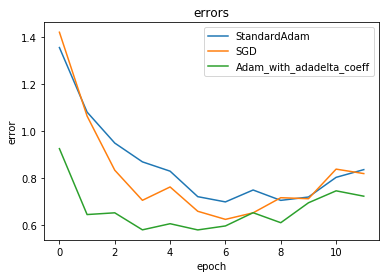

In [26]:
plot_graphs(test_log, 'loss') 

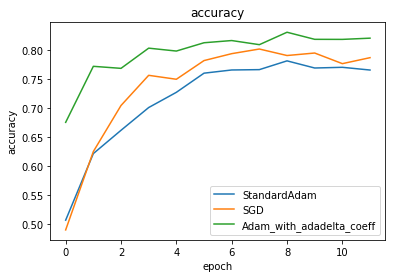

In [27]:
plot_graphs(test_log, 'accuracy')